In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as skl
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Hyper-parameteres
input_size = 2
hidden_sizes = np.array([10,20])
num_classes = 3
num_epochs = 100
batch_size = 50
learning_rate = 0.001

In [5]:
df_class0 = pd.read_csv("./Data/Classification/LS_Group03/Class1.txt", header = None, names = ["x", "y"], sep = ' ')
df_class1 = pd.read_csv("./Data/Classification/LS_Group03/Class2.txt", header = None, names = ["x", "y"], sep = ' ')
# df_class2 = pd.read_csv("./Data/Classification/LS_Group03/Class3.txt", header = None, names = ["x", "y"], sep = ' ')

df_class0['class'] = 1
df_class1['class'] = 2
# df_class2['class'] = 3

all_data = pd.concat([df_class0,df_class1])

df_train, df_test = skl.train_test_split(all_data, test_size = 0.3, train_size = 0.7)

df_train.iloc[:,2] -= 1
df_test.iloc[:,2] -= 1

# converting to tensor
df_train = torch.tensor(np.array(df_train), dtype=torch.float32)
df_test = torch.tensor(np.array(df_test), dtype=torch.float32)
print(df_train.shape, df_test.shape)

torch.Size([700, 3]) torch.Size([300, 3])


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=df_train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=batch_size,shuffle=True)

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        
        layers = []
        
        # Adding the first hidden layer and its activation
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Adding the subsequent hidden layers and their activations
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        
        # Adding the output layer (without activation)
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        # Combining all layers into a sequential container
        self.all_layers = nn.Sequential(*layers)
        
    def forward_propagation(self, x):
        return self.all_layers(x)

In [8]:
model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)



# Train model
total_steps = len(train_loader)

for epoch in range(num_epochs):
    # each iteration will give a batch of points 
    for i,data in enumerate(train_loader): 
        points = data[:, 0:2].clone().detach().float().to(device)
        labels = data[:,2].clone().detach().long().to(device)

        # forward prop
        outputs = model.forward_propagation(points)
        
        loss = loss_fn(outputs, labels)

        # backward prop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1) % 7 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

14
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
Epoch [1/100], Step [7/14], Loss: 0.5185
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
Epoch [1/100], Step [14/14], Loss: 0.4325
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
torch.Size([50, 2]) torch.Size([50, 3]) torch.Size([50])
to

Accuracy of the network on the 300 test images: 100.00 %


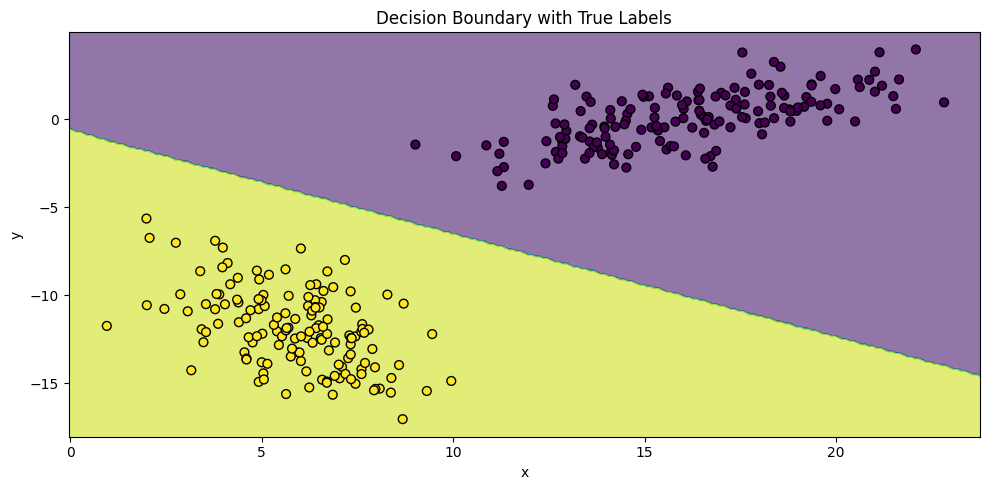

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Evaluate the model and collect predictions
points_list = []
true_labels_list = []
pred_labels_list = []

with torch.no_grad():
    good_pred = 0
    total_samples = len(test_loader.dataset)
    
    for i, data in enumerate(test_loader): 
        points = data[:, 0:2].clone().detach().float().to(device)
        labels = data[:, 2].clone().detach().long().to(device)

        outputs = model.forward_propagation(points)
        _, predictions = torch.max(outputs, 1) # max gives (output value, index)

        good_pred += (predictions == labels).sum().item()

        # Collect data for plotting
        points_list.append(points.cpu())
        true_labels_list.append(labels.cpu())
        pred_labels_list.append(predictions.cpu())

    accuracy = good_pred / total_samples
    print(f'Accuracy of the network on the {total_samples} test images: {100 * accuracy:.2f} %')

# Concatenate all data for plotting
points = torch.cat(points_list)
true_labels = torch.cat(true_labels_list)
pred_labels = torch.cat(pred_labels_list)

# Define the grid for decision boundary
x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

# Get predictions for each point in the grid
with torch.no_grad():
    grid_outputs = model.forward_propagation(grid_points)
    _, grid_predictions = torch.max(grid_outputs, 1)

# Reshape predictions back into the grid shape
grid_predictions = grid_predictions.cpu().numpy().reshape(xx.shape)

# Plot the decision boundary with viridis cmap
plt.figure(figsize=(10, 5))

# Plot the decision boundary
plt.contourf(xx, yy, grid_predictions, alpha=0.6)

# Overlay the true labels with tab10 cmap
plt.scatter(points[:, 0], points[:, 1], c=true_labels, marker='o', edgecolor='k', s=40)
plt.title('Decision Boundary with True Labels')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()
